# Vision transformer for image classification

In this lab you will familiarize yourself with the building blocks of the **transformer** architecture and build a vision transformer (ViT) model for classifying the [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10) dataset. Since ViTs can be computationally expensive to fully train, you will also import a pre trained ViT model and apply it to a series of images of your choice.

Complete the code flagged throughout the elaboration and **answer all the questions in the notebook**.

In [1]:
# Set up and imports
%reload_ext autoreload
%autoreload 2


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Tensorflow is quite chatty; filter out warnings
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

### Check that Tensorflow uses a GPU _(optional)_

Training the models in this notebook can be sped up significantly with a GPU.  The following cell can be used to check if the GPU is set up correctly.  If you run on CPU, you can either run or just ignore this cell.

In [2]:
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

if tf.config.list_physical_devices("GPU"):
    print("✓ Tensorflow has detected a GPU.")
    # Allow growth of GPU memory, otherwise it will always look like all the memory is being used
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("✗ Tensorflow has NOT detected a GPU.")
    print()
    print("For GPU support, visit: <https://www.tensorflow.org/install/pip>")

✓ Tensorflow has detected a GPU.


## The scaled dot-product attention

As you have learned from the lectures and the previous RNN lab, there exist several methods to implement the attention mechanism. In RNN, the attention mechanism generally uses the hidden states of the model to learn to focus the tokens (or elements) in a sequence. The transformer architecture uses the multi-head self-attention (MHSA) mechanism based the scaled dot-product attention. This new way of modeling attention was introduced in the landmark paper by Vaswani et al. in 2017 [Attention is all you need](https://arxiv.org/abs/1706.03762) and it is at the core of modern architectures such as [GPTs](https://en.wikipedia.org/wiki/GPT-3) and [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)).

In the following sections you will, step by step, take a closer look at the building blocks of the MHSA, starting an a visual intuition of how attention works.

### Back to the Future: Nadaraya-Watson kernel regression
Using a data retrieval analogy, imagine you are typing a query in a search engine. Under the hood, an algorithm compares your query with a database of keys and it returns the value corresponding to the key that best-matches your query. Thus, the attention can be viewed as a mapping between the query and the value using the similarity between the query and the keys.

Consider the database $D = {(k_1, v_1), (k_2, v_2),\dots,(k_n, v_n)}$ made of $n$ tuples *(key, value)* pairs. Given a query $q$, we can formulate the attention over $D$ as:
$$
\text{Attention}(q, D) = \sum_{i=1}^n \alpha(q,k_i)v_i,
$$
where $\alpha(q,k_i)$ are scalar values called attention weights. This operation, also referred to as *attention pooling*, is simply a linear combination of the values in the database using the *similarity* between the query and the keys.

A simple, yet educative, example of how this concept can be found in the kernel regression approach initially proposed by [Nadaraya](https://epubs.siam.org/doi/10.1137/1109020) and [Watson](https://www.jstor.org/stable/25049340) in 1964. In they formulation, the similarity metrics $\alpha(q,k_i)$ is chose to be a Gaussian kernel applied to the difference between the query and the keys:
$$
\alpha(q,k) = exp(-\frac{1}{2\sigma^2}||q - k ||^2),
$$
where the attention weight are then used to compute the output of a regressor or classifier as:
$$
f(q) = \sum_{i}v_i\frac{\alpha(q, k_i)}{\sum_{j}\alpha(q, k_i)}.
$$

In the following cell, we will visualize an example of scalar regression where the training samples are tuples of features and labels $(x_i, y_i)$, and the task is to predict the value at a new location. In this case $k$ are the features in out training sample, $v$ are the training labels and $q$ is the new location whose value we want to predict.

In the following cell, we will define the dummy dataset you will work with and visualize how the choice of the parameters defining the Gaussian kernel ($\sigma$ in this case) affects the regressor prediction.


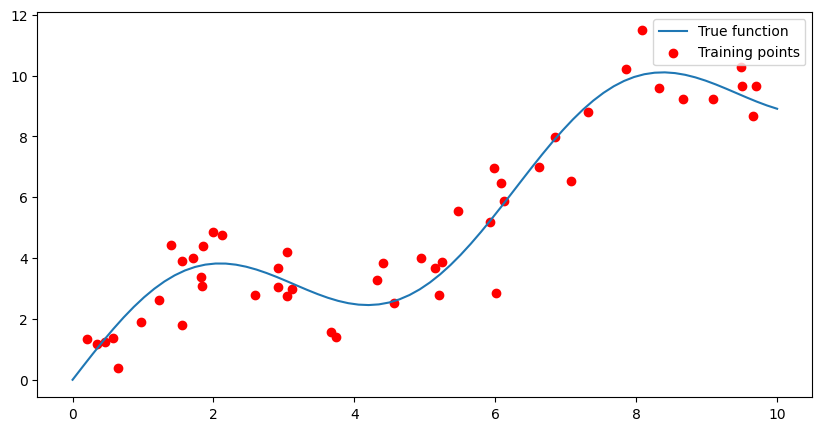

Training set: (50,), (50,)
Validation set: (70,), (70,)


In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# define a random seed for reproducibility
seed = 42
np.random.seed(seed)

# define a function that creates a dummy dataset (sine wave with noise)
def dummy_dataset(x):
    return 2 * np.sin(x) + x

# create a dummy dataset: specify the number of training and validation samples, the range of x values and the noise level
nbr_train = 50
nbr_valid = 70
min_x, max_x = 0, 10

x_train = np.sort(np.random.uniform(min_x, max_x, nbr_train), 0)
y_train = dummy_dataset(x_train) + np.random.normal(0, 1, nbr_train)
x_val = np.linspace(min_x, max_x, nbr_valid)
y_val = dummy_dataset(x_val)

# plot the dataset
plt.figure(figsize=(10, 5))
plt.plot(x_val, y_val, label="True function")
plt.scatter(x_train, y_train, color="red", label="Training points")
plt.legend()
plt.show()

# print the shapes of the training and validation sets
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")

q: (70, 1), k: (50, 1), v: (50, 1)


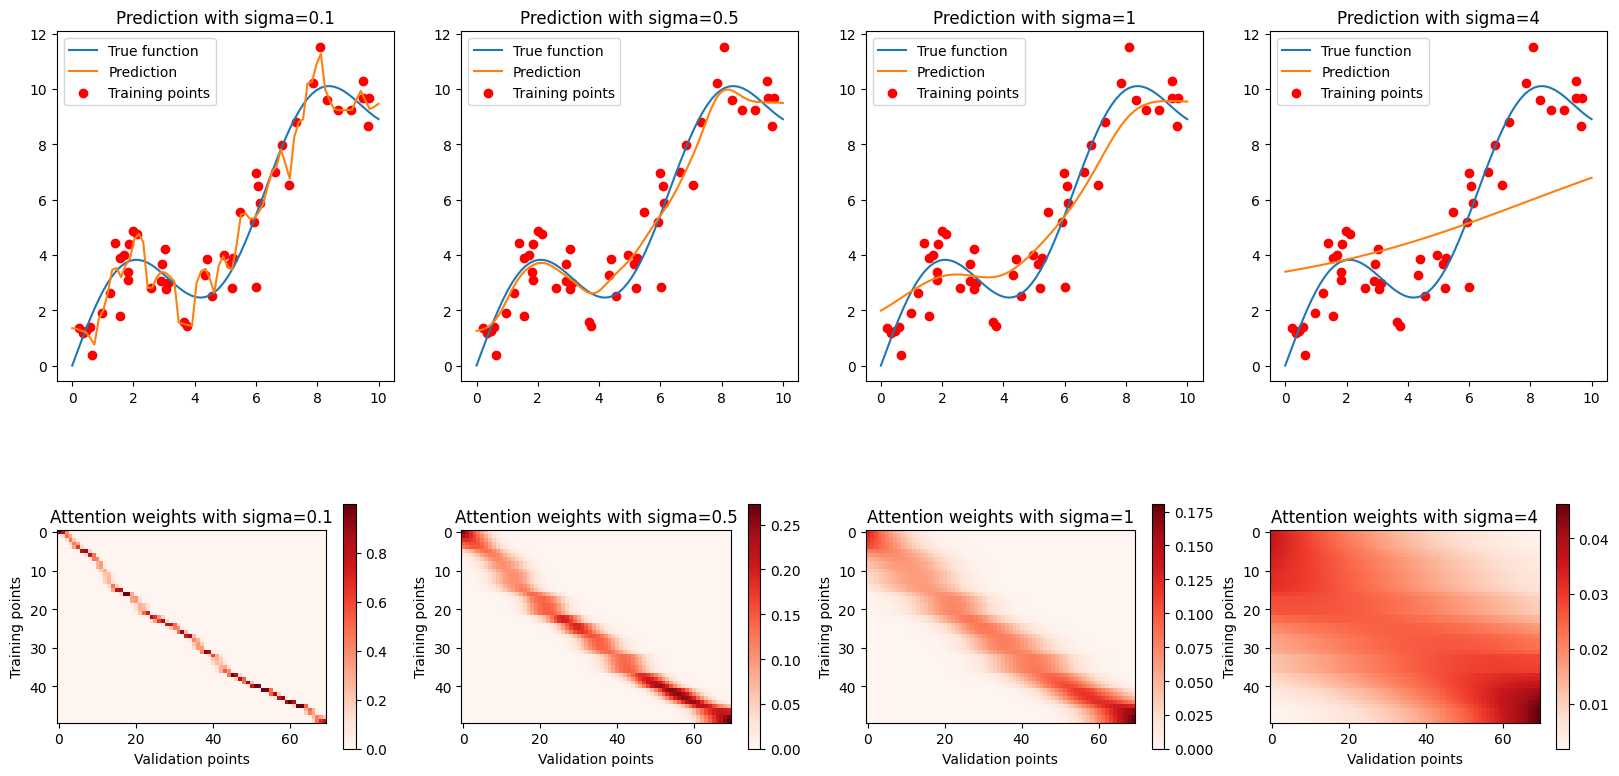

In [4]:
# Define the Gaussian regression kernel
def gaussian(x, sigma=1):
    return np.exp(-(x**2) / (2 * sigma**2))

# define the nadaraya_watson regressor function
def nadaraya_watson(q, k, v, kernel, sigma=1):
    # compute the distance matrix between the training and validation points
    distances = np.linalg.norm(k[:, np.newaxis, :] - q[np.newaxis, :, :], axis=2) # the element-wise difference between the queries and the keys
    # distances = k - q.T
    # Apply the kernel to the distances (across the rows)
    distances = kernel(distances, sigma)
    # Normalize the distances (across the rows) to obtain the attention weights
    attention_weights = distances / np.sum(distances, axis=0)
    # Use the attention weights to compute the prediction
    prediction = attention_weights.T @ v
    return prediction, attention_weights

# define the q, k and v using the dummy dataset (make them N -by- 1)
q = x_val[:, np.newaxis]
k = x_train[:, np.newaxis]
v = y_train[:, np.newaxis]
print(f"q: {q.shape}, k: {k.shape}, v: {v.shape}")

# plot the predictions and the attention weights for different values of sigma.
def plot_predictions(q, k, v, y_val, kernel, sigmas):
    if len(sigmas) == 1:
        fig, axs = plt.subplots(2, 1, figsize=(5, 10))
        axs = axs.reshape(2, 1)
    else:
        fig, axs = plt.subplots(2, len(sigmas), figsize=(20, 10))

    # loop through the sigma values
    for i, sigma in enumerate(sigmas):
        # compute the prediction and attention weights
        prediction, attention_weights = nadaraya_watson(q, k, v, kernel, sigma)
        # plot the prediction
        ax = axs[0, i]
        ax.plot(q, y_val, label="True function")
        ax.plot(q, prediction, label="Prediction")
        ax.scatter(k, v, color="red", label="Training points")
        ax.set_title(f"Prediction with sigma={sigma}")
        ax.legend()
        # plot the attention weights
        ax = axs[1, i]
        attention_plot = ax.imshow(attention_weights, cmap="Reds")
        ax.set_xlabel("Validation points")
        ax.set_ylabel("Training points")
        ax.set_title(f"Attention weights with sigma={sigma}")
        fig.colorbar(attention_plot, ax=ax, shrink=0.7)
    plt.show()

# define the sigma values to test
sigmas = [0.1, 0.5, 1, 4]
# plot the predictions
plot_predictions(q, k, v, y_val, gaussian, sigmas)

As you can see, the similarity kernel we use to attend to the distances greatly influences the prediction of the model. For sharper Gaussian kernels, the spikier the prediction while larger sigmas result in smoother prediction. Finding the best $\sigma$ in the case of a Gaussian kernel or a more suitable kernel among a [variety of kernels](https://en.wikipedia.org/wiki/Kernel_(statistics)) is time consuming. Thus, one can think of designing a model where the parameters of the kernel can be learned. Another way is to keep the similarity function the same but change the representations of the query, keys and values so that when compared thought the similarity function the output is different. As we will see soon, this last solution is what modern transformer architectures learn: they learn how to project $q$, $k$ and $v$ so that similarities are computed over different representations.

#### **<span style="color:red">Questions</span>**
1. Looking at the examples in the Nadaraya - Watson regression, what are the benefits and drawbacks of this type of attention implementation?

#### **<span style="color:green">Answers</span>**
1. The benefits include that it is a simple mechanism with only one parameter that needs to be adjusted and no parameters must be learned over multiple iterations. With the right choice of sigma, overfitting can be mitigated.
Drawbacks are, that a suitable kernel function must be chosen and that finding a good sigma value can take time. It also harder to scale as it uses the kernel function for every single input position.

### Scaled-dot product attention
The choice of a Gaussian regression kernel in the toy example was not by chance. In fact, one can prove that (see [here](https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html) for a more extensive description):

$$
\alpha(q,k_i) = -\frac{1}{2}||q - k_i||^2 = q^\top k_i -\frac{1}{2}||k_i||^2 -\frac{1}{2}||q||^2.
$$
The last term is similar for all the $k_i$, thus when normalizing this element disappears. In addition, as described [here](https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html), $||k_i||^2$ can also be removed in case the keys are themselves normalized (which is usually the case). This brings as close to the definition of the scaled dot-product attention by [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762), which is:
$$
\alpha(q, k_i) = \text{softmax}\left(\frac{q^\top k_i}{\sqrt{d}}\right)
$$
where $q\in\mathbb{R}^d$, $k_i \in \mathbb{R}^d$ and the scaling factor $\sqrt{d}$ ensures that the dot product variance is 1 regardless the query of key vector length $d$. Finally, expanding the formulation to the case where the attention is computed for $m$ queries and using it for attention pooling, we obtain:
$$Z = \text{softmax}\left(\frac{QK^\top}{\sqrt d}\right)V,$$

where $Q\in\mathbb{R}^{m\times d}$ is the matrix of all the query vectors, $K\in\mathbb{R}^{n\times d}$ and $v\in\mathbb{R}^{n\times d}$ is the matrix of all the keys and value vectors, and $Z\in\mathbb{R}^{m\times d}$ is the matrix containing all the weighted value vectors where weights are computed using the similarity between each query vector and the keys using the scaled-dot product attention.


In the next section we will implement the scaled dot-product attention. This implementation should be added to the `utility.py` file. Follow the instructions in the function definition and use the cell below to test your implementation (an error ~ 0.0 should be expected).

In [5]:
from utilities import test_scaled_dot_product_attention

test_scaled_dot_product_attention(seed=42)

############################################
### Testing scaled_dot_product_attention ###
############################################
Random seed set to: 42 (expecting 42)
Testing on Q: (2, 10, 5), K: (2, 5, 5), V: (2, 5, 5)
### scaled_dot_product_attention test failed ###
Output mean difference: 0.0 (expected  0.0).
Output std difference: 0.0 (expected  0.0).
Attention weights mean difference: 1.4901161193847656e-08 (expected  0.0).
Attention weights std difference: -2.9802322387695312e-08 (expected  0.0).
############################################




### Multi-head attention

In practice, when given the same set of queries, keys, and values, we may want our model to integrate knowledge from different aspects using the same attention mechanism. For instance, it can be useful to capture dependencies at varying ranges within a sequence, such as short-range and long-range interactions. To achieve this, the attention mechanism can benefit from utilizing different representation subspaces for queries, keys, and values.

Instead of applying a single attention pooling operation, we can first transform the queries, keys, and values using independently learned linear projections.
These projected versions are then processed through multiple attention pooling operations in parallel.
The resulting outputs from each attention computation—referred to as **heads**—are then concatenated and passed through another learned linear projection to generate the final output.
This architecture is known as multi-head attention [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762), and you can see it visualized in the figure below.
Note the multiple heads, each with its own set of linear projection $W_h^{q}, W_h^{k}$ and $W_h^{v}$ for queries, keys, and values, respectively.

<p align="center">
    <img src="MHA.svg" alt="Multi-Head Attention"/>
</p>

Time to implement the ``MultiHeadAttention``. Follow the instructions of the MultiHeadAttention class in the `utilities.py` file and test your implementation with the cell below.

**NOTE!**: another concept that we will use later is self-attention. In self-attention, the scaled-dot product is computed over projections of the same input sequence. This is particularly useful when we want to encode information taking advantage of short-and-long range dependencies. Self-attention, as you will see later on, is utilized in the Vision Transformer models, to obtain a representation of the input image that can be later used for classification tasks.   

In [6]:
from utilities import test_MultiHeadAttention

# Run the following cell to test your implementation of the MHA layer. IF the test is not passed, check your implementation.
test_MultiHeadAttention(seed=42)

###############################################
### Testing MultiHeadAttention definition ###
###############################################
Random seed set to: 42 (expecting 42)
Testing on Q: (2, 10, 5), K: (2, 5, 5), V: (2, 5, 5)
Number of heads: 2, projection size: 8, dk: 5, dv: 5

### MultiHeadAttention test passed ###
Difference with expected values == 0.0
###############################################


#### **<span style="color:red">Questions</span>**
2. Describe the self-attention mechanism used in vision transformer architecture; how does it differ from that of the attention mechanism you implemented in the RNN lab?
3. What are the computational challenges related with the scaled dot-product attention? Is it more computationally demanding than that of the attention implemented in the RNN?
4. What are the advantages, from a computational perspective, of the scaled dot product compared to attention mechanism implemented in the RNN lab?
5. Can you think of a relation between the multi-head attention you just implemented and convolutional kernels in a CNN architecture?

#### **<span style="color:green">Answers</span>**
2. The self-attention mechanism computes attention scores between all token pairs. The model can therefore globally relate different parts of the image. It works with the scaled dot product while Bahdanau attention, that we used in the RNN lab, uses additive attention. Self-attention is parallizable, while Bahdanau attention must be performed sequentially.
3. As every input token becomes a query and a key we get matrices Q and K with shape (n x d). The attention matrix is the dor product, so it has the shape (n x n). Therefore, the attention scales quadratically. Bahdanau works sequentially, therefore memory is less of a constraint.
4. The self-attention can be parallelized and therefore be sped up, even though is is more computational demanding. Matrix multiplictions are fast performed on GPUs.
5. Convolutional kernels extract features locally. Self-attention works globally. Similar to convolutional kernels, each head extracts different patterns.

### Transformer Encoder Layer

The transformer encoder layer is a fundamental building block of the transformer architecture. It consists of several key components that work together to process input sequences and generate meaningful representations. So far, we have implemented the multi-head attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. However, the full transformer encoder layer includes additional components that are crucial for its functionality:

1. **Multi-Head Attention**: This mechanism enables the model to attend to different positions of the input sequence and capture various aspects of the data. It consists of multiple attention heads, each focusing on different parts of the sequence.

2. **Layer Normalization**: Applied after the multi-head attention and feed-forward layers.

3. **Feed-Forward Neural Network**: This component consists of two linear transformations with a ReLU activation in between. It processes the output of the multi-head attention mechanism to generate more complex representations.

4. **Residual Connections**: These connections add the input of each sub-layer to its output.

5. **Dropout**: Applied to the outputs of the multi-head attention and feed-forward layers, dropout helps prevent overfitting by randomly setting a fraction of the input units to zero during training.

In the next steps, we will implement these additional components to complete the full transformer encoder layer. Add your code in the `utilities.py` file for the following:

1. `mlp` function: defines the feed-forward part of the transformer encoder block. As described in the original implementation, this part of the network is composed by two linear transformations: `proj_dim` -> `2048` -> `proj_dim`.
2. `trasformerBlock` function: it uses the `MultiHeadAttention` and `mlp` to build the full transformer encoder (see image of the transformer architecture - from [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).
<p align="center">
    <img src="ViT_original.png" alt="Vision transformer model"/>
</p>

**NOTE!**: Here we are implementing the `transformerBlock` using the self-attention mechanism, where the query, keys and the values used in the attention pooling are obtained from projections of the save input vector.

In [7]:
from utilities import test_TransformerBlock, transformerBlock

# Run the following cell to test your implementation of the TransformerBlock. If the test is not passed, check your implementation.

test_TransformerBlock(seed=42, dropout_rate=0.1)

###########################################
### Testing transformerBlock definition ###
###########################################
Random seed set to: 42 (expecting 42), dropout rate: 0.1 (expected 0.1)
Testing on Q: (2, 10, 32)
Number of heads: 2, projection size: 32, dx: 32, transformer_units: [64, 32]

### TransformerBlock test passed ###
Difference with expected values == 0.0
###############################################


#### **<span style="color:red">Questions</span>**
6. What is the role of the residual connections in the transformer layer?
7. What is the role of the `Layer Normalization` and why is it needed?

#### **<span style="color:green">Answers</span>**
6. Residual connections help to mitigate the problem of vanishing or exploding gradients and therefore allow deeper architectures.  
7. Layer Normalization guarantees for a stable range of the activation function. Thus, leading to a more stable gradient and therefore improving the convergence.

## Vision transformer

Now that you have implemented the core mechanism of a transformer architecture, we can apply it to for an image classification task. In the following cells, you will implement the remaining parts of a vision transformer (ViT) architecture and train a model for the classification of the **CIFAR10** dataset.

As an overview, a vision transformer model is composed by four components:
1. `PatchExtraction`: given the computational complexity on the (self) scaled-dot product attention is $O(n^2 d)$, applying the attention mechanism on the raw pixel values will be unfeasible for real world images. Thus, in the landmark paper that introduced the transformer architecture for computer vision tasks ([An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)), the authors split in image into squared patches (16 $\times$ 16 in the original implementation), which are flattened (or encoded) and used as input to the transformer architecture.
2. `PatchEncoder`: the scaled-dot product attention comes with the benefit of parallel computation but disregards the order of the input sequence. This is a problem when it comes to both vision and language modelling, where the order if the input sequence (*i.e.* the information regarding the closeness of pixels in an image) carries information. To address this issue, a **positional embedding** is added to each element in the sequence, providing information on both the position of an element in a sequence, and a feature within an element. (**NOTE!**: in this lab we will use the `Embedding` Keras layer to add positional encoding. The original implementation proposes a positional embedding based on sine & cosine function. These are not the only ways of implementing positional encoding, with modern architecture allowing for the positional encoding to be learned during training).
3. **Stack of transformer layers**: this is where the input image (patched and positional-encoded) traverses sequentially multiple transformer layers (`transformerBlock` in our implementation) to obtain a representation that gathers information from all the image regions and that can be used for a downstream task (classification) in this case.

**There is one problem though...** The the end of a sequence of transformer layers we obtain a new representation (based on the multi-head self attention mechanism) for each of the patches in the image.
- **How do we use this for classification? Do we pick one of the patches as representative for the entire sequence? But then how to chose?**
- **Or do we apply a dense layer that combines all the sequences into one sequence?**

What is done in the original implementation is to add a learnable sequence element, called the class token (`cls` token) during the `PatchEncoder`, which thought the transformer layers interacts with all the elements in the sequence. The `cls` token is then used as a representation of the entire input for the downstream task.

4. **Classification layer**: usually a dense layer recieves as input the `cls` token and outputs logits (is working on a classification task).

In the following cells you will first download the CIFAR10 dataset, and implement the `PatchExtraction`, `PatchEncoder` and the full `ViT` model architecture. You will then train it on the CIFAR10 dataset.

### Load, preprocess and visualize the dataset

Similar to what we have done in the CNN lab, we will download the CIFAR10 dataset, split it into training, validation and testing, and normalize it.

Training/validation images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training/validation images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training/validation examples for class 0 is 1005
Number of training/validation examples for class 1 is 974
Number of training/validation examples for class 2 is 1032
Number of training/validation examples for class 3 is 1016
Number of training/validation examples for class 4 is 999
Number of training/validation examples for class 5 is 937
Number of training/validation examples for class 6 is 1030
Number of training/validation examples for class 7 is 1001
Number of training/validation examples for class 8 is 1025
Number of training/validation examples for class 9 is 981


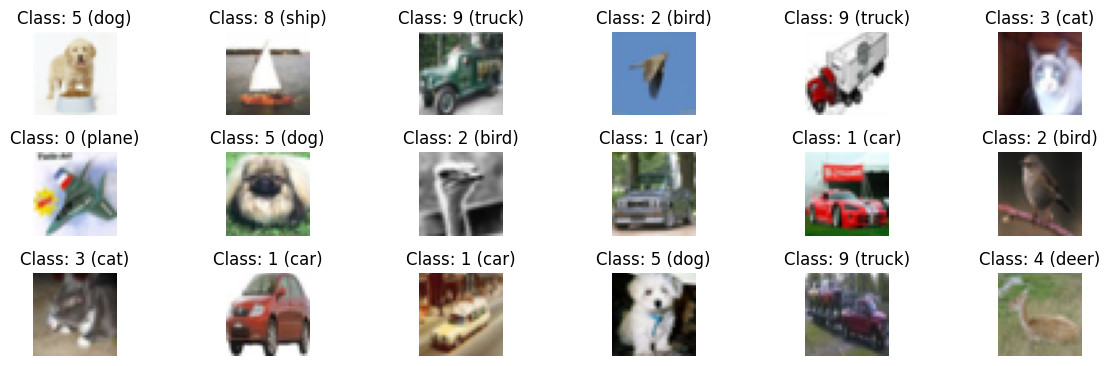

In [8]:
from tf_keras.datasets import cifar10
from tf_keras.utils import to_categorical
from utilities import plot_training_examples

# Load and preprocess the CIFAR10 dataset (here we are using the tf_keras.dataset functionality)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(X, Y), (Xtest, Ytest) = cifar10.load_data()

print("Training/validation images have size {} and labels have size {} ".format(X.shape, Y.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# # Reduce the number of images for training/validation and testing to 10000 and 2000 respectively,
# # to reduce processing time for this elaboration.
X = X[0:10000]
Y = Y[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

print("Reduced training/validation images have size %s and labels have size %s " % (X.shape, Y.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training/validation examples for class {} is {}" .format(i,np.sum(Y == i)))

# Plot some images from the dataset to visualize it
plot_training_examples(X, Y, classes)

#### Data split

Split your data (X, Y) into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration).

We use the `train_test_split` function from scikit learn (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more details) to obtain 25% validation set.

In [9]:
from sklearn.model_selection import train_test_split

# -----------------------------------------
# === Your code here for data splitting ===
# -----------------------------------------

# split the original dataset into 70% Training and 30% Temp
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.3, stratify=Y)

# Print the size of training data, validation data and test data

# ============================================

#### Image preprocessing

The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255.

NOTE! that is this lab we will be using the labels as NOT categorical (we did that in the CNN lab).

In [10]:
# --------------------------------------------------
# === Your code here for intensity normalization ===
# --------------------------------------------------

# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

# ============================================

### PatchExtraction

Follow the instructions in the `utilities.py` file to implement the `PatchExtraction` as Keras layer. Use the cell below to verify that the patching is done correctly.

Original image shape: (1, 32, 32, 3)
Shape of the encoded image: (1, 16, 192)


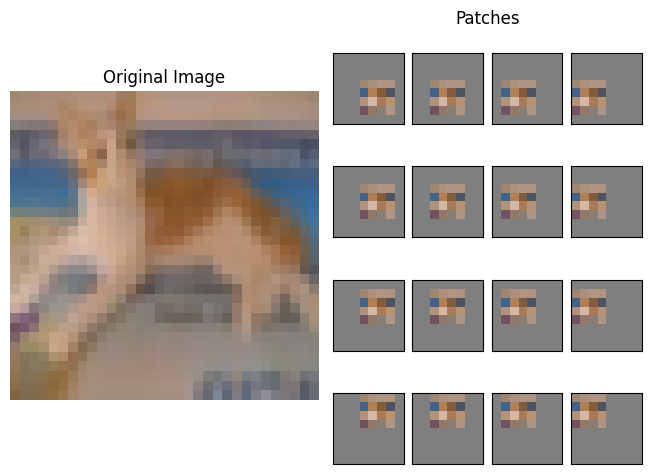

In [11]:
from utilities import PatchExtractor, plot_original_and_patched_version

# take a sample image from the training set
sample_image = Xtrain[0]
# add a batch dimension
sample_image = sample_image[tf.newaxis, ...]

# create a PatchExtractor object
patch_size = 8
patches_extractor = PatchExtractor(patch_size=patch_size)

# encode the sample image
patches = patches_extractor(sample_image)

# print the shape of the encoded image
print(f"Original image shape: {sample_image.shape}")
print(f"Shape of the encoded image: {patches.shape}")

# Plot the original image and the patched image as a grid of patches

plot_original_and_patched_version(sample_image[0], patches, patch_size)

### PatchEncoder

Complete with your code in the `PatchEncoder` class in the `utility.py` file. It is here that the `cls` token will be added to the sequence of patches. Run the following cell to test your implementation.

In [12]:
from utilities import PatchEncoder, PatchExtractor

# take a sample image from the training set
sample_image = Xtrain[0]
# add a batch dimension
sample_image = sample_image[tf.newaxis, ...]

# create a PatchExtractor object
patch_size = 8
patches_extractor = PatchExtractor(patch_size=patch_size)

# encode the sample image
patches = patches_extractor(sample_image)

# Use the patches extracted from the sample image above and encode them using the PatchEncoder
patch_encoder = PatchEncoder(num_patches=patches.shape[1], projection_dim=patches.shape[-1])

# encode the patches
encoded_patches = patch_encoder(patches)

# print the shape of the encoded patches
print(f"Shape of the encoded patches: {encoded_patches.shape}")


Shape of the encoded patches: (1, 17, 192)


#### **<span style="color:red">Questions</span>**
8. Can you think of another way of encoding the patch information instead of linearly projecting them?
9. The transformer architecture is quite general anc can be applied to images, text or other types of input data. This flexibility comes at a cost, especially when it comes to computer vision tasks. Can you think at what this might be? (Hint: think about the properties of the convolution operation and its benefits when it comes to computer vision task.)

#### **<span style="color:green">Answers</span>**
8. Instead of linearly projecting we could also use a convolutional layer. This way, local information could be preserved.  
9. The way that the input data is handeled results in the loss of positional information.

### Putting all together - ViT model

Now you have implemented all the components of a ViT model. Add your code to the `create_vit_classifier` function in the `utilities.py` file and check the model summary with the following cell. Use the following model parameter settings:
- `patch_size`: 16
- `embedding_proj_dim` == `msa_proj_dim`: 768
- `num_heads`: 12
- `transformer_layers`: 12
- `msa_dropout_rate`: 0.1
- `mlp_classification_head_units`: [ 3074 ]
-  `mlp_classification_head_dropout_rate`: 0.5

In [13]:
from utilities import create_vit_classifier

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# create a ViT model
## define all the model parameters (here we use a dictionary to store them)
model_params = {
    # dataset information
    "input_shape": (32,32,3),
    "num_classes": 10,
    # patch extraction
    "patch_size": 16,
    # patch encoder
    "embedding_proj_dim": 768,
    # transformer encoder
    "num_heads": 12,
    "msa_proj_dim": 768,
    "transformer_layers": 12,
    "msa_dropout_rate": 0.1,
    # classification head
    "mlp_classification_head_units": [3074],
    "mlp_classification_head_dropout_rate": 0.5
}

# ============================================

# create the model
vit = create_vit_classifier(**model_params)

# print the model summary
vit.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 patch_extractor_2 (PatchEx  (None, 4, 768)               0         ['input_1[0][0]']             
 tractor)                                                                                         
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 5, 768)               595200    ['patch_extractor_2[0][0]']   
 der)                                                                                             
                                                                                              

#### **<span style="color:red">Questions</span>**
10. Check the original ViT paper and look for the number of model parameters given the same model configurations. Do we have the same number of training parameters? If not, why is this the case? (Hint! compare how the projection matrices are defined in the paper and how we have defined them).

#### **<span style="color:green">Answers</span>**
10. The ViT-Base model from the original paper has 86M parameters, while ours has 371M. The difference between the implementation is in the projection matrices of the multi-head attention. The original paper has one projection and splits it into heads internally, while we compute a projection for each singular head. This results in 28M parameters in each of our multi head attention layer.

### Model training

In the next cell, you will define the training helper function that defines the loss, the optimizer and runs the model training and testing given a dataset. Follow the instructions in the cell below and train your first model.

In [14]:
import tf_keras
import tensorflow as tf

from tf_keras.optimizers import Adam # import the optimizer you want to use
from tf_keras.losses import SparseCategoricalCrossentropy # import the loss function you want to use
from tf_keras.metrics import SparseCategoricalAccuracy # keep these since we define the callback to use them

from utilities import plot_classifier_training_history

def run_experiment(
        model,
        training_data = (Xtrain, Ytrain),
        validation_data = (Xval, Yval),
        test_data = (Xtest, Ytest),
        epochs=10,
        batch_size=64,
        learning_rate=1e-4,
        ckpt_path=".",
        run_testing=True,
    ):
    '''
    Function to run the experiment

    PArameters:
        model: the model to train
        training_data (tuple): tuple of training data (Xtrain, Ytrain)
        validation_data (tuple): tuple of validation data (Xval, Yval)
        test_data (tuple): tuple of test data (Xtest, Ytest)
        epochs (int): number of epochs to train the model
        batch_size (int): batch size for training
        learning_rate (float): learning rate for the optimizer
        top_k (int): top k accuracy to track during training
        ckpt_path (str): path to save the model checkpoint
        run_testing (bool): whether to run testing after training

    Returns:
        history: the training history
    '''
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------

    # define the optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # define loss
    loss = SparseCategoricalCrossentropy()

    # ============================================

    # We define additional metrics to track during training and a callback to save the best model
    metrics = [
        SparseCategoricalAccuracy(name="accuracy")
        ]

    # define auxiliary callback (save the best model based on validation accuracy)
    checkpoint_filepath = os.path.join(ckpt_path, "checkpoint.weights.h5")
    checkpoint_callback = tf_keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------

    # compile model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )

    # train model
    history = model.fit(
        x=training_data[0],
        y=training_data[1],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(validation_data),
        callbacks=[checkpoint_callback],
    )

    # ============================================
    print("Training completed.")

    # evaluate model on the test set
    if run_testing:
        print("\nEvaluating model on the test data.")
        # after model training, load the best weights and evaluate on the test set
        model.load_weights(checkpoint_filepath)
        _, accuracy = model.evaluate(test_data[0], test_data[1])
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return history


Epoch 1/10
110/110 [==============================] - 107s 698ms/step - loss: 4.3393 - accuracy: 0.1134 - val_loss: 2.7620 - val_accuracy: 0.1403
Epoch 2/10
110/110 [==============================] - 168s 2s/step - loss: 2.8307 - accuracy: 0.1181 - val_loss: 2.5655 - val_accuracy: 0.1523
Epoch 3/10
110/110 [==============================] - 38s 350ms/step - loss: 2.5629 - accuracy: 0.1239 - val_loss: 2.3476 - val_accuracy: 0.1157
Epoch 4/10
110/110 [==============================] - 40s 362ms/step - loss: 2.4474 - accuracy: 0.1229 - val_loss: 2.4370 - val_accuracy: 0.1273
Epoch 5/10
110/110 [==============================] - 39s 352ms/step - loss: 2.4200 - accuracy: 0.1237 - val_loss: 2.2936 - val_accuracy: 0.1390
Epoch 6/10
110/110 [==============================] - 160s 1s/step - loss: 2.3744 - accuracy: 0.1287 - val_loss: 2.2731 - val_accuracy: 0.1527
Epoch 7/10
110/110 [==============================] - 38s 347ms/step - loss: 2.3309 - accuracy: 0.1321 - val_loss: 2.2976 - val_accur

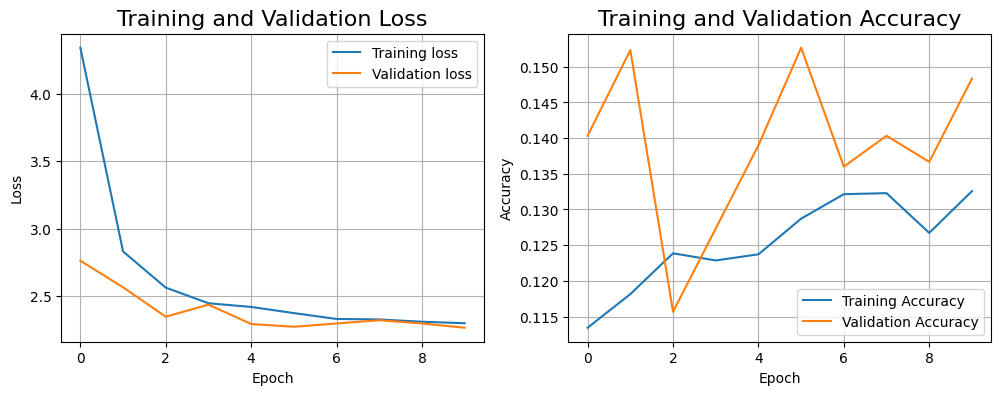

In [15]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Use the run_experiment function to train the model
history = run_experiment(
            model = vit,
            training_data=(Xtrain, Ytrain),
            validation_data=(Xval, Yval),
            test_data=(Xtest, Ytest),
            epochs=10,
            batch_size=64,
            learning_rate=0.001)

# ============================================

# plot the training history
plot_classifier_training_history(history)

#### **<span style="color:red">Questions</span>**
11. Compare the model performance for the ViT and the CNN mode that you trained in the CNN lab. Which one obtained a higher classification accuracy?
12. There is one regularization method that we did not implement in this lab that we did in the CNN lab when it comes to the data. What is it? Can this improve model performance and generalization?
13. Can you think how the output of a ViT model as implemented in this lab can be used for image segmentation?

#### **<span style="color:green">Answers</span>**
11. Our ViT is barely better than the naive classifier with a test accuracy of around 0.16. The CNN model was significantly better, with a test accuracy of around 0.57.
12. Data augmentation, that we implemented in the CNN lab, can be viewed as a form of regularization, as it lets the model generalize better and therefore reduces overfitting. It would also improve the performance of a ViT, especially as transformers require more data than e.g. CNNs.
13. Currently we predict one class label for the whole image. But we could also perform classifications for each patch. This way the result would be a segmentation of the image in different classes.


## Carbon footprint

Compare the carbon footprint of training a Vision Transformer (ViT) model to that of a CNN model, as done in the CNN lab. Adjust the number of training and testing samples to match those used in the CNN lab, and set the batch size and number of epochs to the same values. After training the ViT model, measure the energy consumption (kWh) and CO₂ emissions (grams) and compare them to the values obtained for the CNN model.

In [21]:
from carbontracker.tracker import CarbonTracker

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# NOTE: Change the number of training and testing samples so that it matches that of the CNN lab (there we used 10000 training samples and 2000 testing samples)

# define model
model_params = {
    # dataset information
    "input_shape": (32,32,3),
    "num_classes": 10,
    # patch extraction
    "patch_size": 16,
    # patch encoder
    "embedding_proj_dim": 768,
    # transformer encoder
    "num_heads": 12,
    "msa_proj_dim": 768,
    "transformer_layers": 12,
    "msa_dropout_rate": 0.1,
    # classification head
    "mlp_classification_head_units": [3074],
    "mlp_classification_head_dropout_rate": 0.5
}

# create the model
vit = create_vit_classifier(**model_params)

# define experiment parameters as a dictionary
experiment_params = {
    "model": vit,
    "training_data": (Xtrain[0:7500], Ytrain[0:7500]),
    "validation_data": (Xval[0:2500], Yval[0:2500]),
    "test_data": (Xtest[0:2000], Ytest[0:2000]),
    "epochs": 20,
    "batch_size": 128, # differs from CNN lab, but no bigger batch size possible due to memory constraints
    "learning_rate": 1e-4,
    "ckpt_path": ".",
    "run_testing": True
}

# run the experiment with carbontracker
# Create a CarbonTracker object
tracker = CarbonTracker(epochs=experiment_params["epochs"])

# start carbon tracking
tracker.epoch_start()

# run the experiment
history = run_experiment(**experiment_params)

tracker.epoch_end()

CarbonTracker: The following components were found: GPU with device(s) Tesla T4.
CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carbon intensity 369.47318 gCO2/kWh.
Epoch 1/20
55/55 [==============================] - 95s 1s/step - loss: 2.6961 - accuracy: 0.1493 - val_loss: 2.3698 - val_accuracy: 0.1496
Epoch 2/20
55/55 [==============================] - 49s 903ms/step - loss: 2.5144 - accuracy: 0.1459 - val_loss: 2.3086 - val_accuracy: 0.1700
Epoch 3/20
55/55 [==============================] - 34s 619ms/step - loss: 2.4602 - accuracy: 0.1377 - val_loss: 2.2333 - val_accuracy: 0.1544
Epoch 4/20
55/55 [==============================] - 33s 610ms/step - loss: 2.3702 - accuracy: 0.1533 - val_loss: 2.2516 - val_accuracy: 0.1640
Epoch 5/20
55/55 [==============================] - 33s 608ms/step - loss: 2.4056 - accuracy: 0.1426 - val_loss: 2.2953 - val_acc

#### **<span style="color:red">Questions</span>**
14. Compare the carbon footprint for training a ViT model with that of the CNN model of the CNN lab: which one had the highest footprint? Describe what is the reason of the difference.

#### **<span style="color:green">Answers</span>**
15. The CO2-emission for the ViT is significantly higher. For the training of 20 epochs more than 185g are produced, while for the CNN it was only 0.13g. The reason behind the huge difference is, that the ViT has significantly more trainable parameters. The CNN parameters have  size of roughly 500 KB, while the ViT's are more than 1GB big.

## Pre-trained ViT model

As for the CNN lab, there exist a variety of pre-trained ViT models that can be imported and used as they are for natural image classification. Tensorflow and Keras do not have pre-trained versions the ViT architecture in their repository. For this reason, here we are using the `transformer` library that loads Pytorch ViT model weights into a Tensorflow-defined model. See the [documentation](https://huggingface.co/docs/transformers/index) for more information.

In [16]:
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from tf_keras.utils import load_img, img_to_array

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# load the image and preprocess it (similar to the CNN lab)
image = load_img("elpresidente.png", target_size=(224, 224))
image = img_to_array(image)
# ============================================

# Define a feature extractor and a model: here we will load the vit-base-patch16-224 model
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Pre-process the image and make a prediction
inputs = feature_extractor(images=image, return_tensors="tf")
outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = tf.math.argmax(logits, axis=-1)[0]
print("Predicted class:", model.config.id2label[int(predicted_class_idx)])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Predicted class: suit, suit of clothes


## (OPTIONAL) Transformers for text summarization

In this next section you can play around with a sequence-to-sequence (Seq2Seq) transformer model for text summarization. As before, we will use a pre-trained model from the `transformer` library. In this example we will use the [T5 model](https://arxiv.org/abs/1910.10683) which can be prompted to perform several NLP tasks, such as summarization.

For short text, you can input the text directly as a variable. For longer texts, copy it into a .txt file, which will be then loaded and fed to the model. You will see that the longer the input text, the better the answer.

In [ ]:
# Load both the tokenizer and the model
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

In [ ]:
# Load .txt or input text for summary manually

# Load the text file
with open('NLP_text.txt', 'r') as file:
    text = file.read()

# Or input text manually
# text = 'Some text to summarize'

# get the number of words in the text
nbr_words = len(text.split())
# set the maximum length of the model output to 50% of the number of original words
max_length = int(0.5 * nbr_words)
# set the minimum number of output words to 10
min_length = 10

# print the number of words in the text
print(f"Number of words in the text: {nbr_words}")

In [ ]:
# specify the task that the model should perform
task = 'summarize'
# create the input string for the model and pass it thought the tokenizer
input_ids = tokenizer(f"{task} : {text}", return_tensors="tf").input_ids
# generate model outputs
outputs = model.generate(input_ids, max_length=max_length, min_length=min_length, do_sample=True)

# print model output
print(tokenizer.decode(outputs[0], skip_special_tokens=True))